In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


In [1]:
import pandas as pd
from scipy import stats

# file
file_paths = ['2018.xlsx', '2019.xlsx', '2020.xlsx', '2021.xlsx', '2022.xlsx', '2023.xlsx', '2024.xlsx']

# threshold
threshold = 0.2

# Traverse different files
for index, file_path in enumerate(file_paths):
    # read a file
    excel_file = pd.ExcelFile(file_path)

    # Get all table names
    sheet_names = excel_file.sheet_names

    # Traverse different worksheets
    for sheet_name in sheet_names:
        df = excel_file.parse(sheet_name)

        # Preprocess the 2022 data by converting object type columns containing numerical values to numerical types
        if index == 4:
            object_columns = df.select_dtypes(include=['object']).columns
            for col in object_columns:
                if col not in ['Country', 'Happiness Rank']:
                    df[col] = df[col].str.replace(',', '.').astype(float)

        # Fill in missing values with mean
        for col in df.columns:
            if df[col].dtype in ['int64', 'float64']:
                mean_value = df[col].mean()
                df[col].fillna(mean_value, inplace=True)

        # Perform normality test (Shapiro Wilk test) and determine correlation coefficient
        normal_columns = []
        non_normal_columns = []
        for col in df.columns:
            if col not in ['Happiness score', 'Happiness Score'] and df[col].dtype in ['int64', 'float64']:
                _, p_value = stats.shapiro(df[col])
                if p_value > 0.05:
                    normal_columns.append(col)
                else:
                    non_normal_columns.append(col)

        # Select the correlation coefficient based on the normality test results and calculate the correlation coefficient
        if normal_columns:
            pearson_corr = df[normal_columns + ['Happiness score' if 'Happiness score' in df.columns else 'Happiness Score']].corr()
            happiness_pearson_corr = pearson_corr['Happiness score' if 'Happiness score' in df.columns else 'Happiness Score'].drop('Happiness score' if 'Happiness score' in df.columns else 'Happiness Score')
            selected_pearson_features = happiness_pearson_corr[abs(happiness_pearson_corr) > threshold].index
            print(f'File path: {file_path}, Sheet name: {sheet_name}, Features selected using Pearson correlation coefficient: {selected_pearson_features}')
            print(f'Pearson correlation coefficients with Happiness Score: {happiness_pearson_corr}')

        if non_normal_columns:
            spearman_corr = df[non_normal_columns + ['Happiness score' if 'Happiness score' in df.columns else 'Happiness Score']].corr(method='spearman')
            happiness_spearman_corr = spearman_corr['Happiness score' if 'Happiness score' in df.columns else 'Happiness Score'].drop('Happiness score' if 'Happiness score' in df.columns else 'Happiness Score')
            selected_spearman_features = happiness_spearman_corr[abs(happiness_spearman_corr) > threshold].index
            print(f'File path: {file_path}, Sheet name: {sheet_name}, Features selected using Spearman correlation coefficient: {selected_spearman_features}')
            print(f'Spearman correlation coefficients with Happiness Score: {happiness_spearman_corr}')

File path: 2018.xlsx, Sheet name: 2018, Features selected using Spearman correlation coefficient: Index(['Happiness rank', 'Economy', 'Social support',
       'Healthy life expectancy', 'Freedom', 'Perceptions of corruption'],
      dtype='object')
Spearman correlation coefficients with Happiness Score: Happiness rank              -0.999998
Economy                      0.822604
Social support               0.775751
Healthy life expectancy      0.793352
Freedom                      0.534761
Generosity                   0.112308
Perceptions of corruption    0.257464
Name: Happiness Score, dtype: float64
File path: 2019.xlsx, Sheet name: 2019, Features selected using Spearman correlation coefficient: Index(['Happiness rank', 'Economy', 'Social support',
       'Healthy life expectancy', 'Freedom ', 'Perceptions of corruption'],
      dtype='object')
Spearman correlation coefficients with Happiness Score: Happiness rank              -0.999999
Economy                      0.814483
Social su

In [2]:
import pandas as pd

# file
excel_file = pd.ExcelFile('combined_data.xlsx')


sheet_names = excel_file.sheet_names
sheet_names

['2018']

In [3]:
# Retrieve data from the specified worksheet
df = excel_file.parse('2018')


print('Basic Data Information：')
df.info()

# View the number of rows and columns in the dataset
rows, columns = df.shape

if rows < 100 and columns < 20:

    print('All content information of the data：')
    print(df.to_csv(sep='\t', na_rep='nan'))
else:
   
    print('The first few lines of data contain information：')
    print(df.head().to_csv(sep='\t', na_rep='nan'))

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Happiness rank             1052 non-null   int64  
 1   Country                    1052 non-null   object 
 2   Happiness Score            1052 non-null   float64
 3   Economy                    1049 non-null   object 
 4   Social support             1049 non-null   object 
 5   Healthy life expectancy    1048 non-null   object 
 6   Freedom                    1049 non-null   object 
 7   Generosity                 1049 non-null   object 
 8   Perceptions of corruption  1048 non-null   object 
 9   Year                       1052 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 82.3+ KB
数据前几行内容信息：
	Happiness rank	Country	Happiness Score	Economy	Social support	Healthy life expectancy	Freedom	Generosity	Perceptions of corruption	Year
0	

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


cols = ['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

imputer = SimpleImputer(strategy='mean')
df[cols] = imputer.fit_transform(df[cols])

# Define feature variables and target variables
X = df[['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption', 'Year']]
y = df['Happiness Score']

# Divide the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# fitted model
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

# measure
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mse：{mse}')
print(f'R2：{r2}')

# predict
new_data = df[['Country', 'Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption']]
new_data['Year'] = 2025


happiness_2025 = model.predict(new_data[['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption', 'Year']])

new_data['Happiness Score 2025'] = happiness_2025


new_data = new_data[new_data['Happiness Score 2025'] < 10]


new_data[['Country', 'Happiness Score 2025']]

均方误差：510401.5736381163
R方值：0.8613588294860919


C:\Users\32125\AppData\Local\Temp\ipykernel_28260\3207388285.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Year'] = 2025
C:\Users\32125\AppData\Local\Temp\ipykernel_28260\3207388285.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Happiness Score 2025'] = happiness_2025


Empty DataFrame
Columns: [Country, Happiness Score 2025]
Index: []

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


cols = ['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


imputer = SimpleImputer(strategy='mean')
df[cols] = imputer.fit_transform(df[cols])


X = df[['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption', 'Year']]
y = df['Happiness Score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mse：{mse}')
print(f'R2：{r2}')


new_data = df[['Country', 'Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption']]
new_data['Year'] = 2025


happiness_2025 = model.predict(new_data[['Economy', 'Social support', 'Healthy life expectancy', 'Freedom', 'Perceptions of corruption', 'Year']])


new_data['Happiness Score 2025'] = happiness_2025


new_data = new_data[new_data['Happiness Score 2025'] < 10]


new_data[['Country', 'Happiness Score 2025']]

均方误差：53667.88952943502
R方值：0.9854221079877636


C:\Users\32125\AppData\Local\Temp\ipykernel_26376\3198773537.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Year'] = 2025
C:\Users\32125\AppData\Local\Temp\ipykernel_26376\3198773537.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Happiness Score 2025'] = happiness_2025


Country  Happiness Score 2025
0              Finland              7.606830
1               Norway              7.562780
2              Denmark              7.638860
3              Iceland              7.050240
4          Switzerland              7.463320
...                ...                   ...
1047  Congo (Kinshasa)              3.775770
1048      Sierra Leone              4.339620
1049           Lesotho              3.726900
1050           Lebanon              3.089572
1051       Afghanistan              2.320100

[903 rows x 2 columns]

In [11]:
new_data = new_data[new_data['Happiness Score 2025'] < 10].head(150)
new_data['Happiness Rank'] = new_data.index + 1

result = new_data[['Country', 'Happiness Rank', 'Happiness Score 2025']]
result.to_excel('happiness_prediction_2025.xlsx', index=False)

In [10]:
import plotly.express as px
from IPython.display import display
import plotly.graph_objects as go
import plotly.io as pio
df = pd.read_excel('2024.xlsx')
df = df.fillna(0)
#Create a world happiness index map using Plotly Express
fig = px.choropleth(
    df,
    locations='Country',
    locationmode='country names',
    color='Happiness score',
    color_continuous_scale='YlGnBu',
    hover_name='Country',
    hover_data=['Happiness Rank', 'Economy', 'Social support','Healthy life expectancy','Freedom','Perceptions of corruption'],
    title='World Happiness Index'
)


fig.update_geos(
    showcoastlines=True,
    coastlinecolor='RebeccaPurple',
    showland=True,
    landcolor='LightGrey',
    showocean=True,
    oceancolor='white',
    projection_type='equirectangular',  
    lonaxis=dict(
        showgrid=False,
        dtick=30,
        range=[-180, 180]
    ),
    lataxis=dict(
        showgrid=False,
        dtick=30,
        range=[-90, 90]
    )
)


fig.update_layout(
    geo=dict(
        showframe=True,
        framecolor='black',
        framewidth=2,
        fitbounds="locations",
        projection=dict(
            type="equirectangular",  
            scale=1
        )
    ),
     xaxis=dict(
        title='Longitude',
        title_font=dict(size=16, color='black'),
        tickfont=dict(size=12, color='black'),  
        showline=True,  
        linewidth=1, 
        linecolor='black',  
        mirror=True, 
        tickformat='.0f°',
        showticklabels=True
    ),
    yaxis=dict(
        title='Latitude',
        title_font=dict(size=16, color='black'),
        tickfont=dict(size=12, color='black'), 
        tickformat='.0f°',
        showline=True, 
        linewidth=1, 
        linecolor='black', 
        mirror=True, 
        showticklabels=True  
    ),
    width=1200,
    height=600,
    title=dict(
        text='World Happiness Index Map',
        x=0.5,
        font=dict(size=24, color='black')
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

plt.rcParams['font.family'] = 'Times New Roman'
display(fig)

In [13]:
import plotly.express as px
from IPython.display import display
import plotly.graph_objects as go
import plotly.io as pio
df = pd.read_excel('happiness_prediction_2025.xlsx')
df = df.fillna(0)
#Create a world happiness index map using Plotly Express
fig = px.choropleth(
    df,
    locations='Country',
    locationmode='country names',
    color='Happiness Score 2025',
    color_continuous_scale='YlGnBu',
    hover_name='Country',
    hover_data=['Happiness Rank'],
    title='World Happiness Index'
)


fig.update_geos(
    showcoastlines=True,
    coastlinecolor='RebeccaPurple',
    showland=True,
    landcolor='LightGrey',
    showocean=True,
    oceancolor='white',
    projection_type='equirectangular',  
    lonaxis=dict(
        showgrid=False,
        dtick=30,
        range=[-180, 180]
    ),
    lataxis=dict(
        showgrid=False,
        dtick=30,
        range=[-90, 90]
    )
)


fig.update_layout(
    geo=dict(
        showframe=True,
        framecolor='black',
        framewidth=2,
        fitbounds="locations",
        projection=dict(
            type="equirectangular",  
            scale=1
        )
    ),
     xaxis=dict(
        title='Longitude',
        title_font=dict(size=16, color='black'),
        tickfont=dict(size=12, color='black'),  
        showline=True,  
        linewidth=1, 
        linecolor='black',  
        mirror=True, 
        tickformat='.0f°',
        showticklabels=True
    ),
    yaxis=dict(
        title='Latitude',
        title_font=dict(size=16, color='black'),
        tickfont=dict(size=12, color='black'), 
        tickformat='.0f°',
        showline=True, 
        linewidth=1, 
        linecolor='black', 
        mirror=True, 
        showticklabels=True  
    ),
    width=1200,
    height=600,
    title=dict(
        text='World Happiness Index Map',
        x=0.5,
        font=dict(size=24, color='black')
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

plt.rcParams['font.family'] = 'Times New Roman'
display(fig)

C:\Users\32125\AppData\Local\Temp\ipykernel_26376\1067898077.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



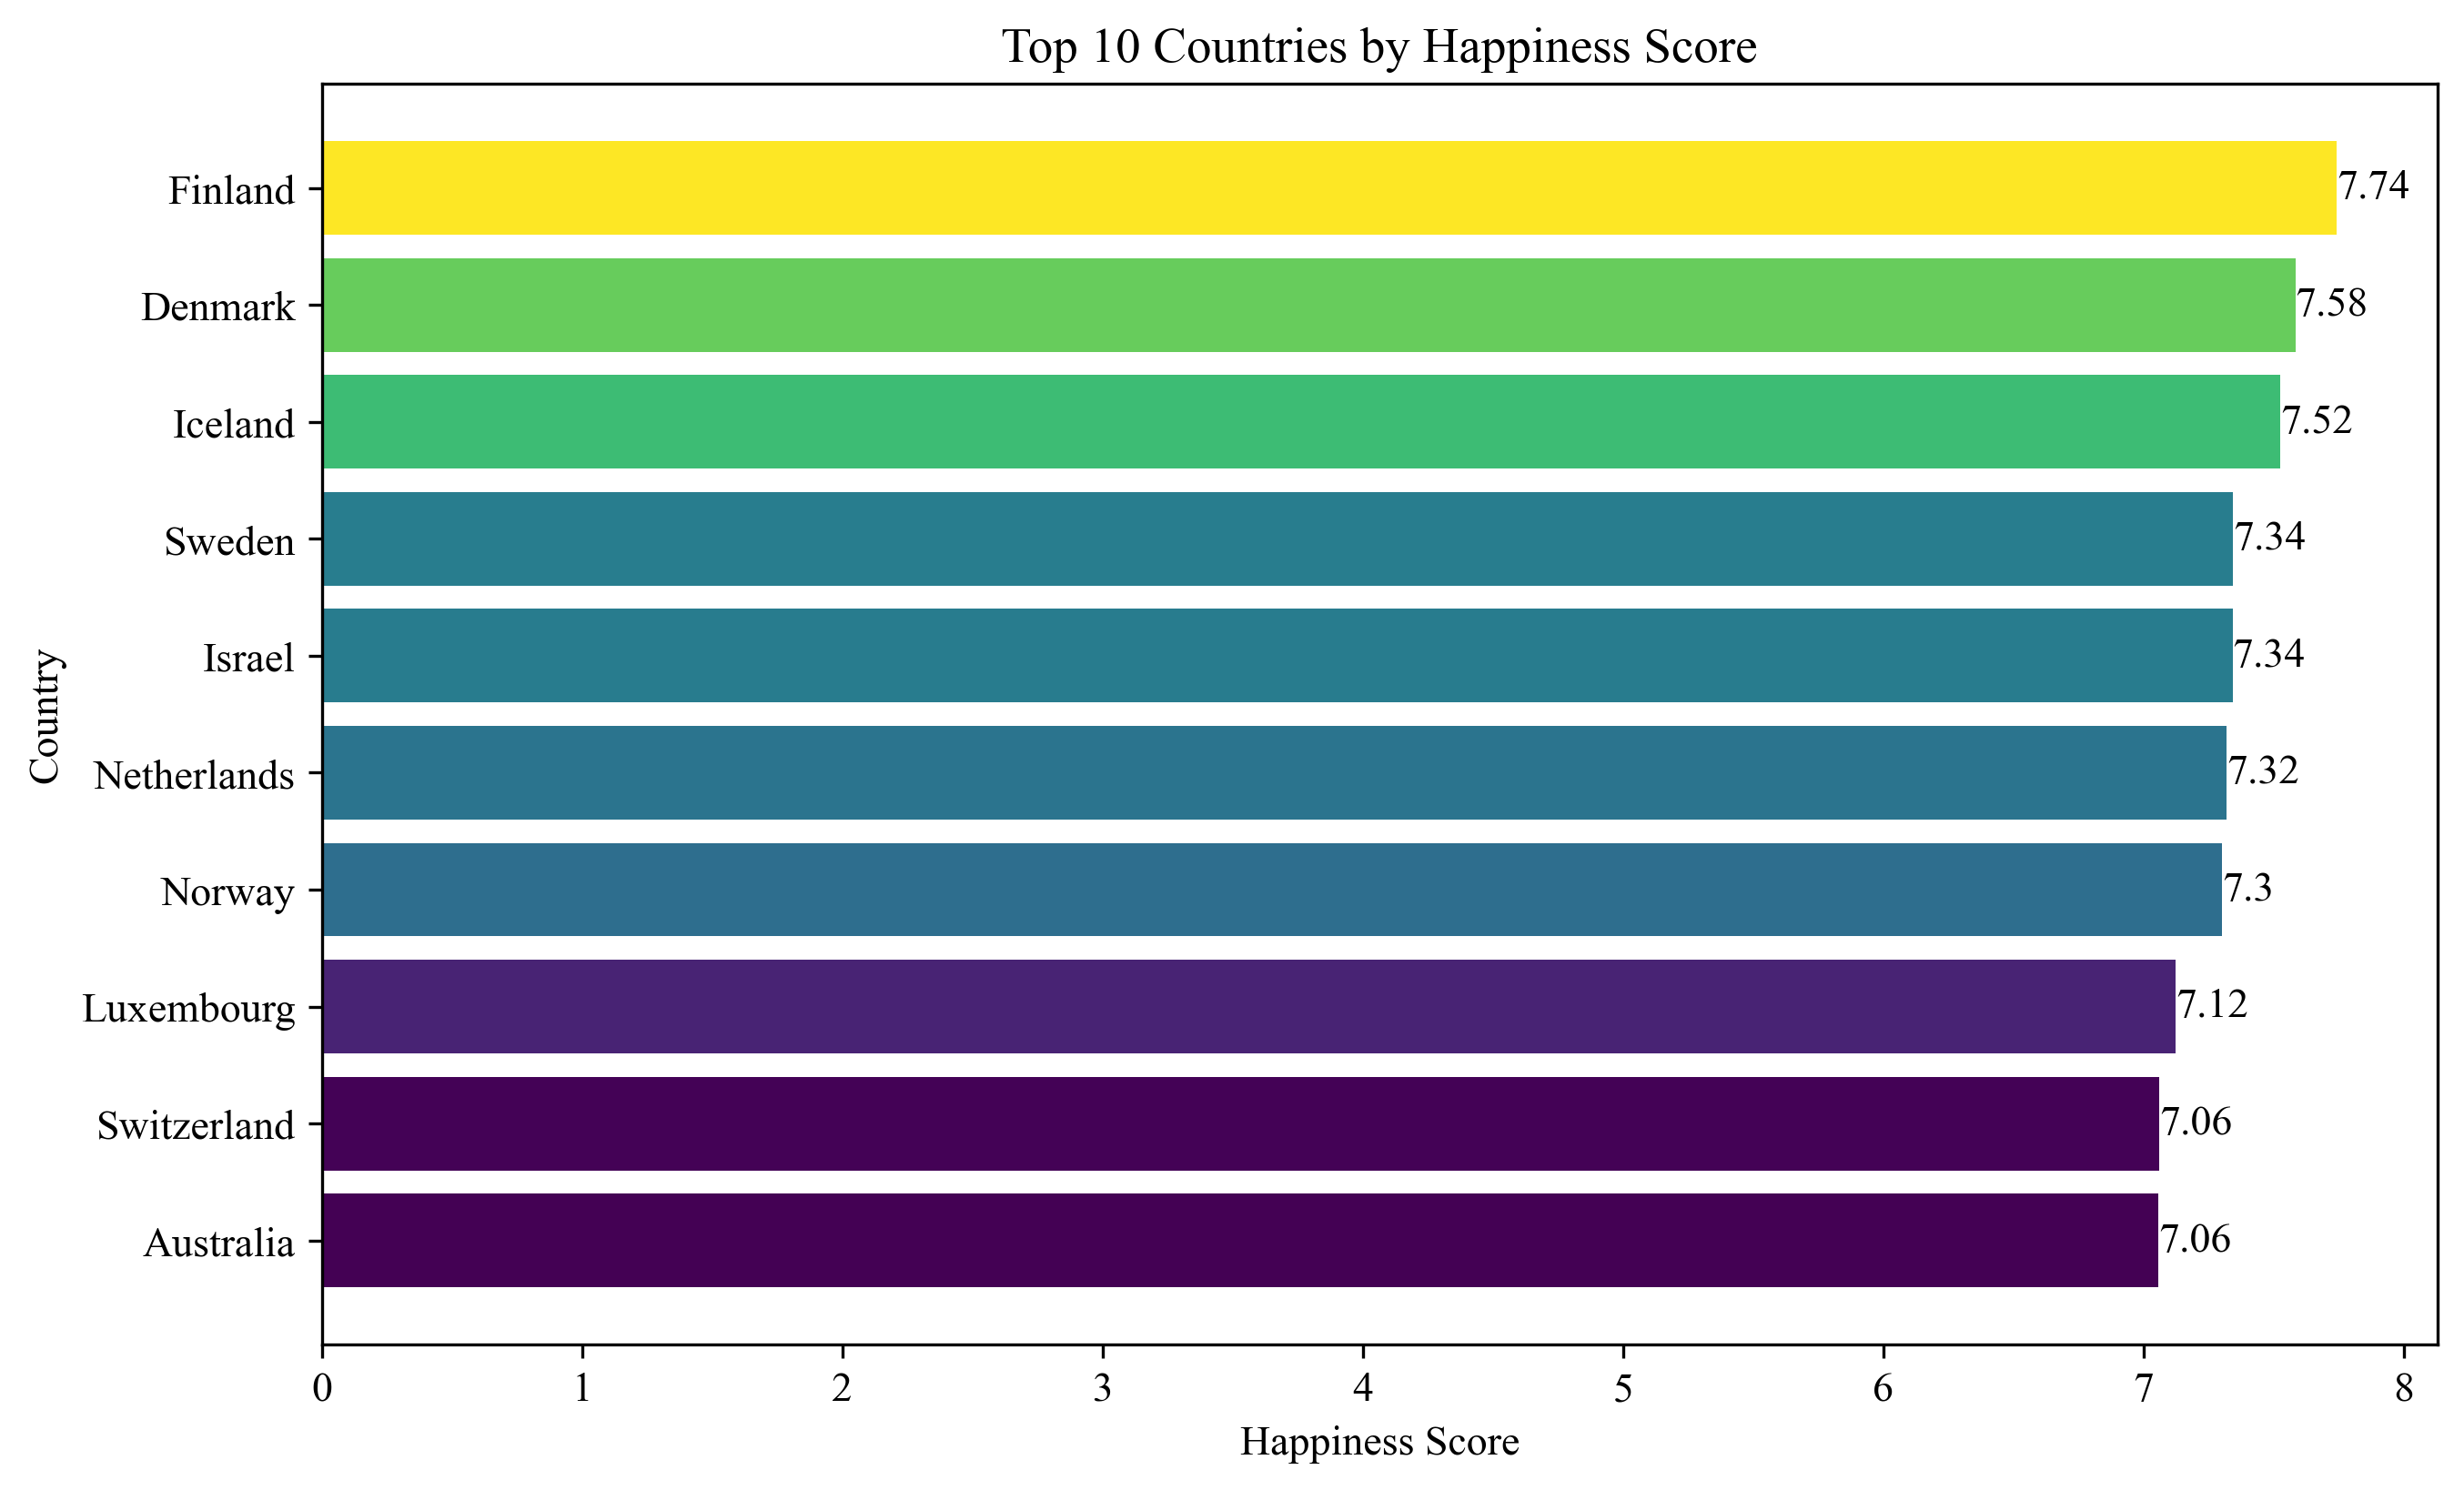

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
df = pd.read_excel('2024.xlsx')
df = df.fillna(0)
# 1: Create barplot
top_10 = df.nsmallest(10, 'Happiness Rank').sort_values(by='Happiness Rank', ascending=False)


plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 11})

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))


norm = Normalize(vmin=top_10['Happiness score'].min(), vmax=top_10['Happiness score'].max())
colormap = cm.get_cmap('viridis')

#top 10 countries by Happiness Score
for i, country in enumerate(top_10['Country']):
    score = top_10['Happiness score'].iloc[i]
    color = colormap(norm(score))
    plt.barh(country, score, color=color)


for i, country in enumerate(top_10['Country']):
    score = top_10['Happiness score'].iloc[i]
    plt.text(score, i, str(round(score, 2)), va='center')
plt.grid(False)

plt.title('Top 10 Countries by Happiness Score')
plt.ylabel('Country')
plt.xlabel('Happiness Score')


plt.show()

C:\Users\32125\AppData\Local\Temp\ipykernel_26376\3516944035.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



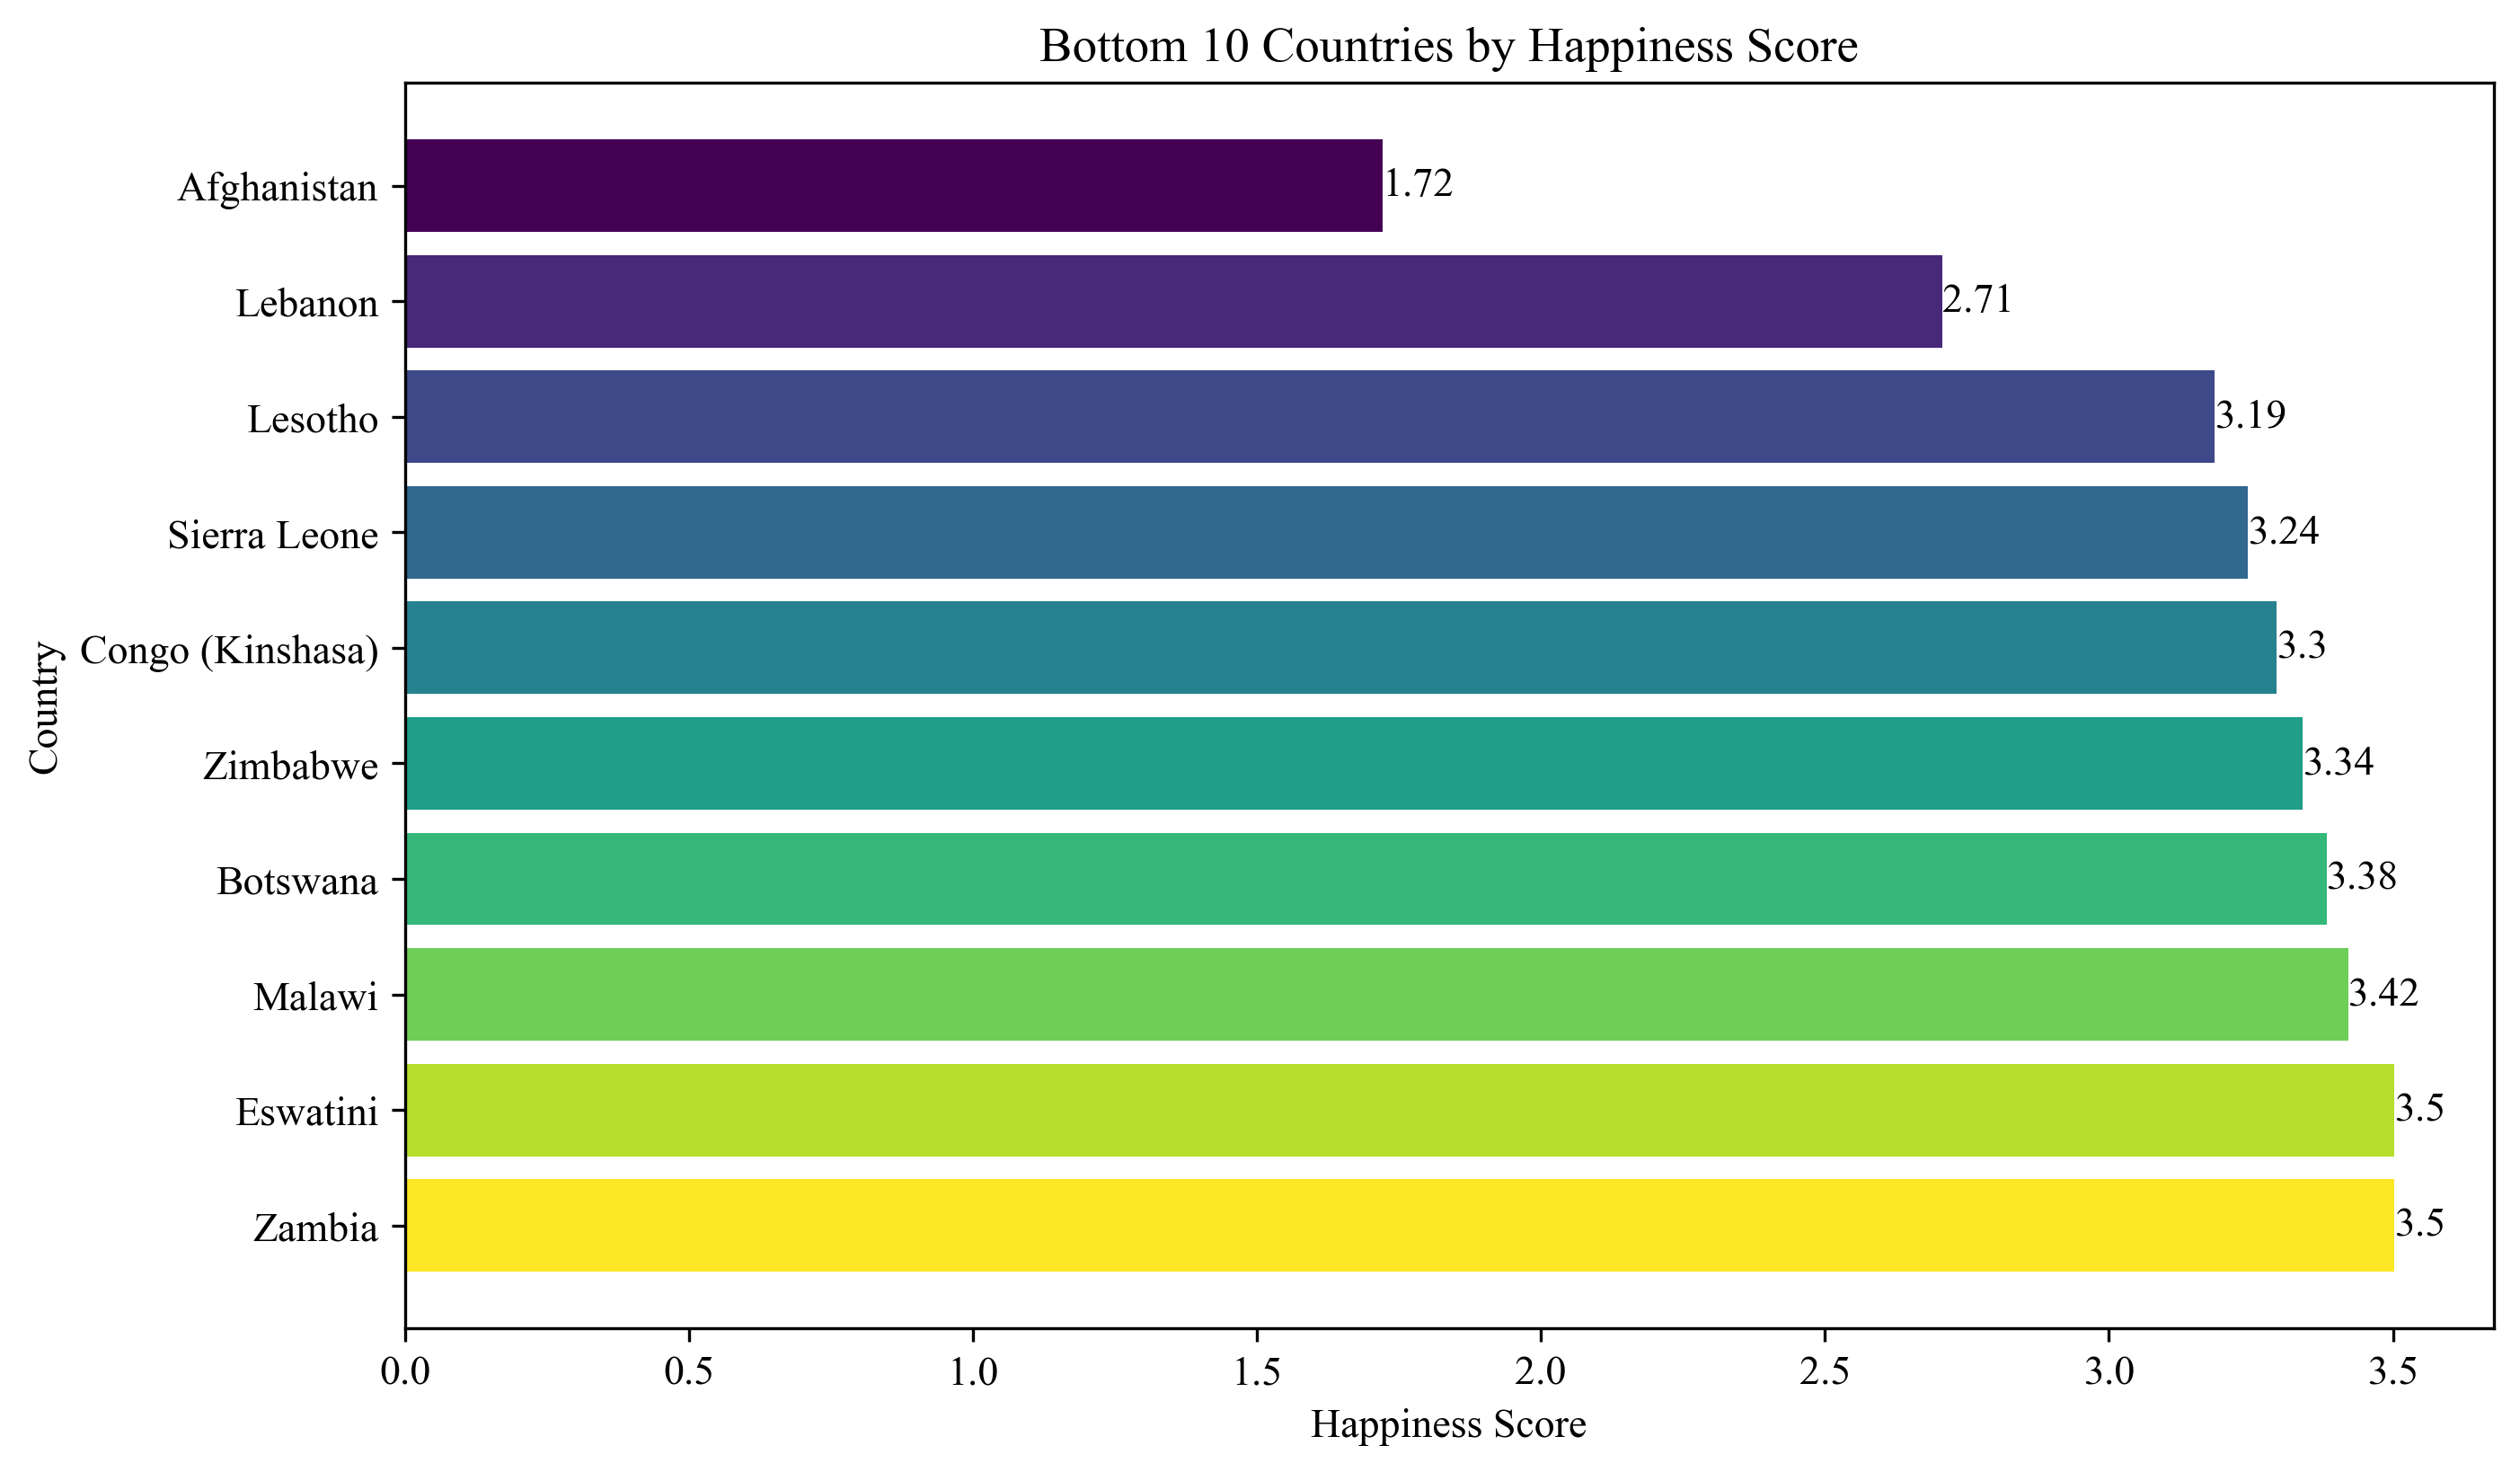

In [16]:

# Select the 10 countries with the lowest happiness scores and sort them in ascending order by rank

bottom_10 = df.nlargest(10, 'Happiness Rank').sort_values(by='Happiness Rank')

# Set the figure resolution
plt.rcParams.update({'font.size': 11})

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 300

# Create a figure with a specified size

plt.figure(figsize=(10, 6))

# Create a custom color map with a smaller color span and reverse it. Here we use a lighter part of the 'viridis' colormap.

colormap = cm.get_cmap('viridis', 10).reversed()

# Plot horizontal bar charts and set colors

for i, country in enumerate(bottom_10['Country']):
    score = bottom_10['Happiness score'].iloc[i]
    color = colormap(i)
    plt.barh(country, score, color=color)

# Add data labels

for i, country in enumerate(bottom_10['Country']):
    score = bottom_10['Happiness score'].iloc[i]
    plt.text(score, i, str(round(score, 2)), va='center')

# Set the chart title and axis labels
plt.grid(False)
plt.title('Bottom 10 Countries by Happiness Score')
plt.ylabel('Country')
plt.xlabel('Happiness Score')

# Display the chart

plt.show()

C:\Users\32125\AppData\Local\Temp\ipykernel_26376\452302386.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



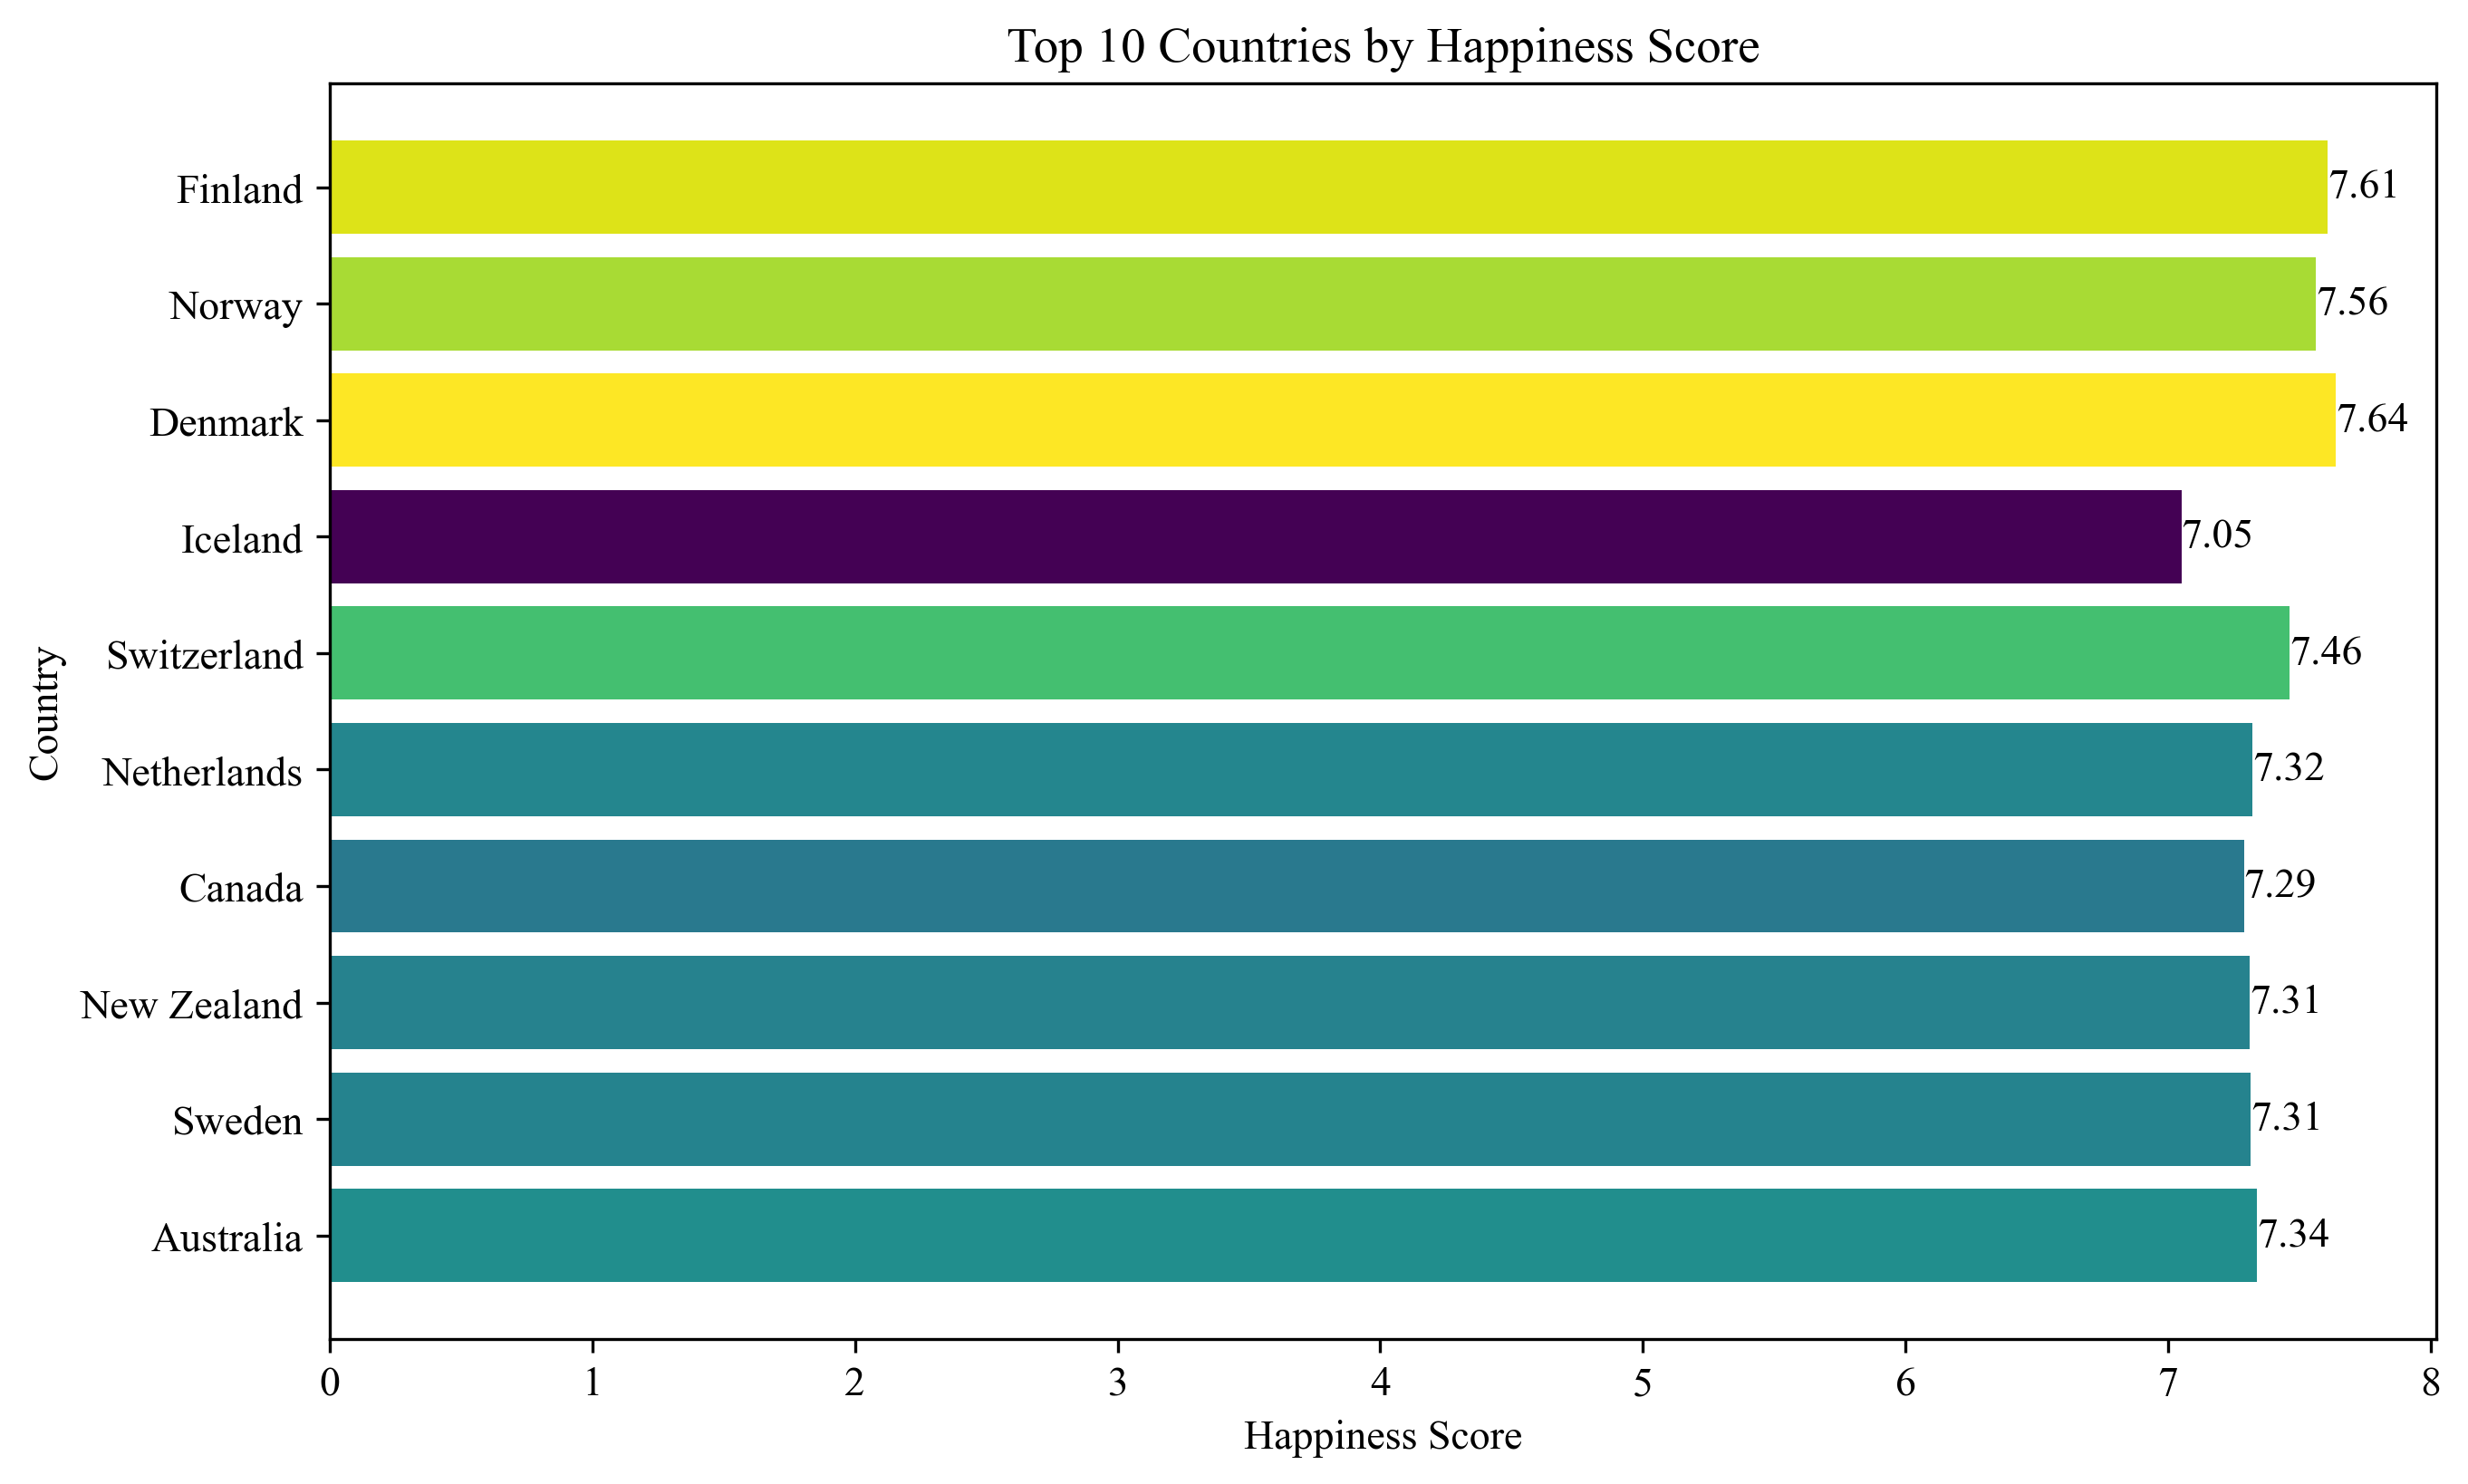

In [19]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
df = pd.read_excel('happiness_prediction_2025.xlsx')
df = df.fillna(0)
# 1: Create barplot
top_10 = df.nsmallest(10, 'Happiness Rank').sort_values(by='Happiness Rank', ascending=False)


plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 11})

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))


norm = Normalize(vmin=top_10['Happiness Score 2025'].min(), vmax=top_10['Happiness Score 2025'].max())
colormap = cm.get_cmap('viridis')

#top 10 countries by Happiness Score
for i, country in enumerate(top_10['Country']):
    score = top_10['Happiness Score 2025'].iloc[i]
    color = colormap(norm(score))
    plt.barh(country, score, color=color)


for i, country in enumerate(top_10['Country']):
    score = top_10['Happiness Score 2025'].iloc[i]
    plt.text(score, i, str(round(score, 2)), va='center')
plt.grid(False)

plt.title('Top 10 Countries by Happiness Score')
plt.ylabel('Country')
plt.xlabel('Happiness Score')


plt.show()

C:\Users\32125\AppData\Local\Temp\ipykernel_26376\2613446746.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



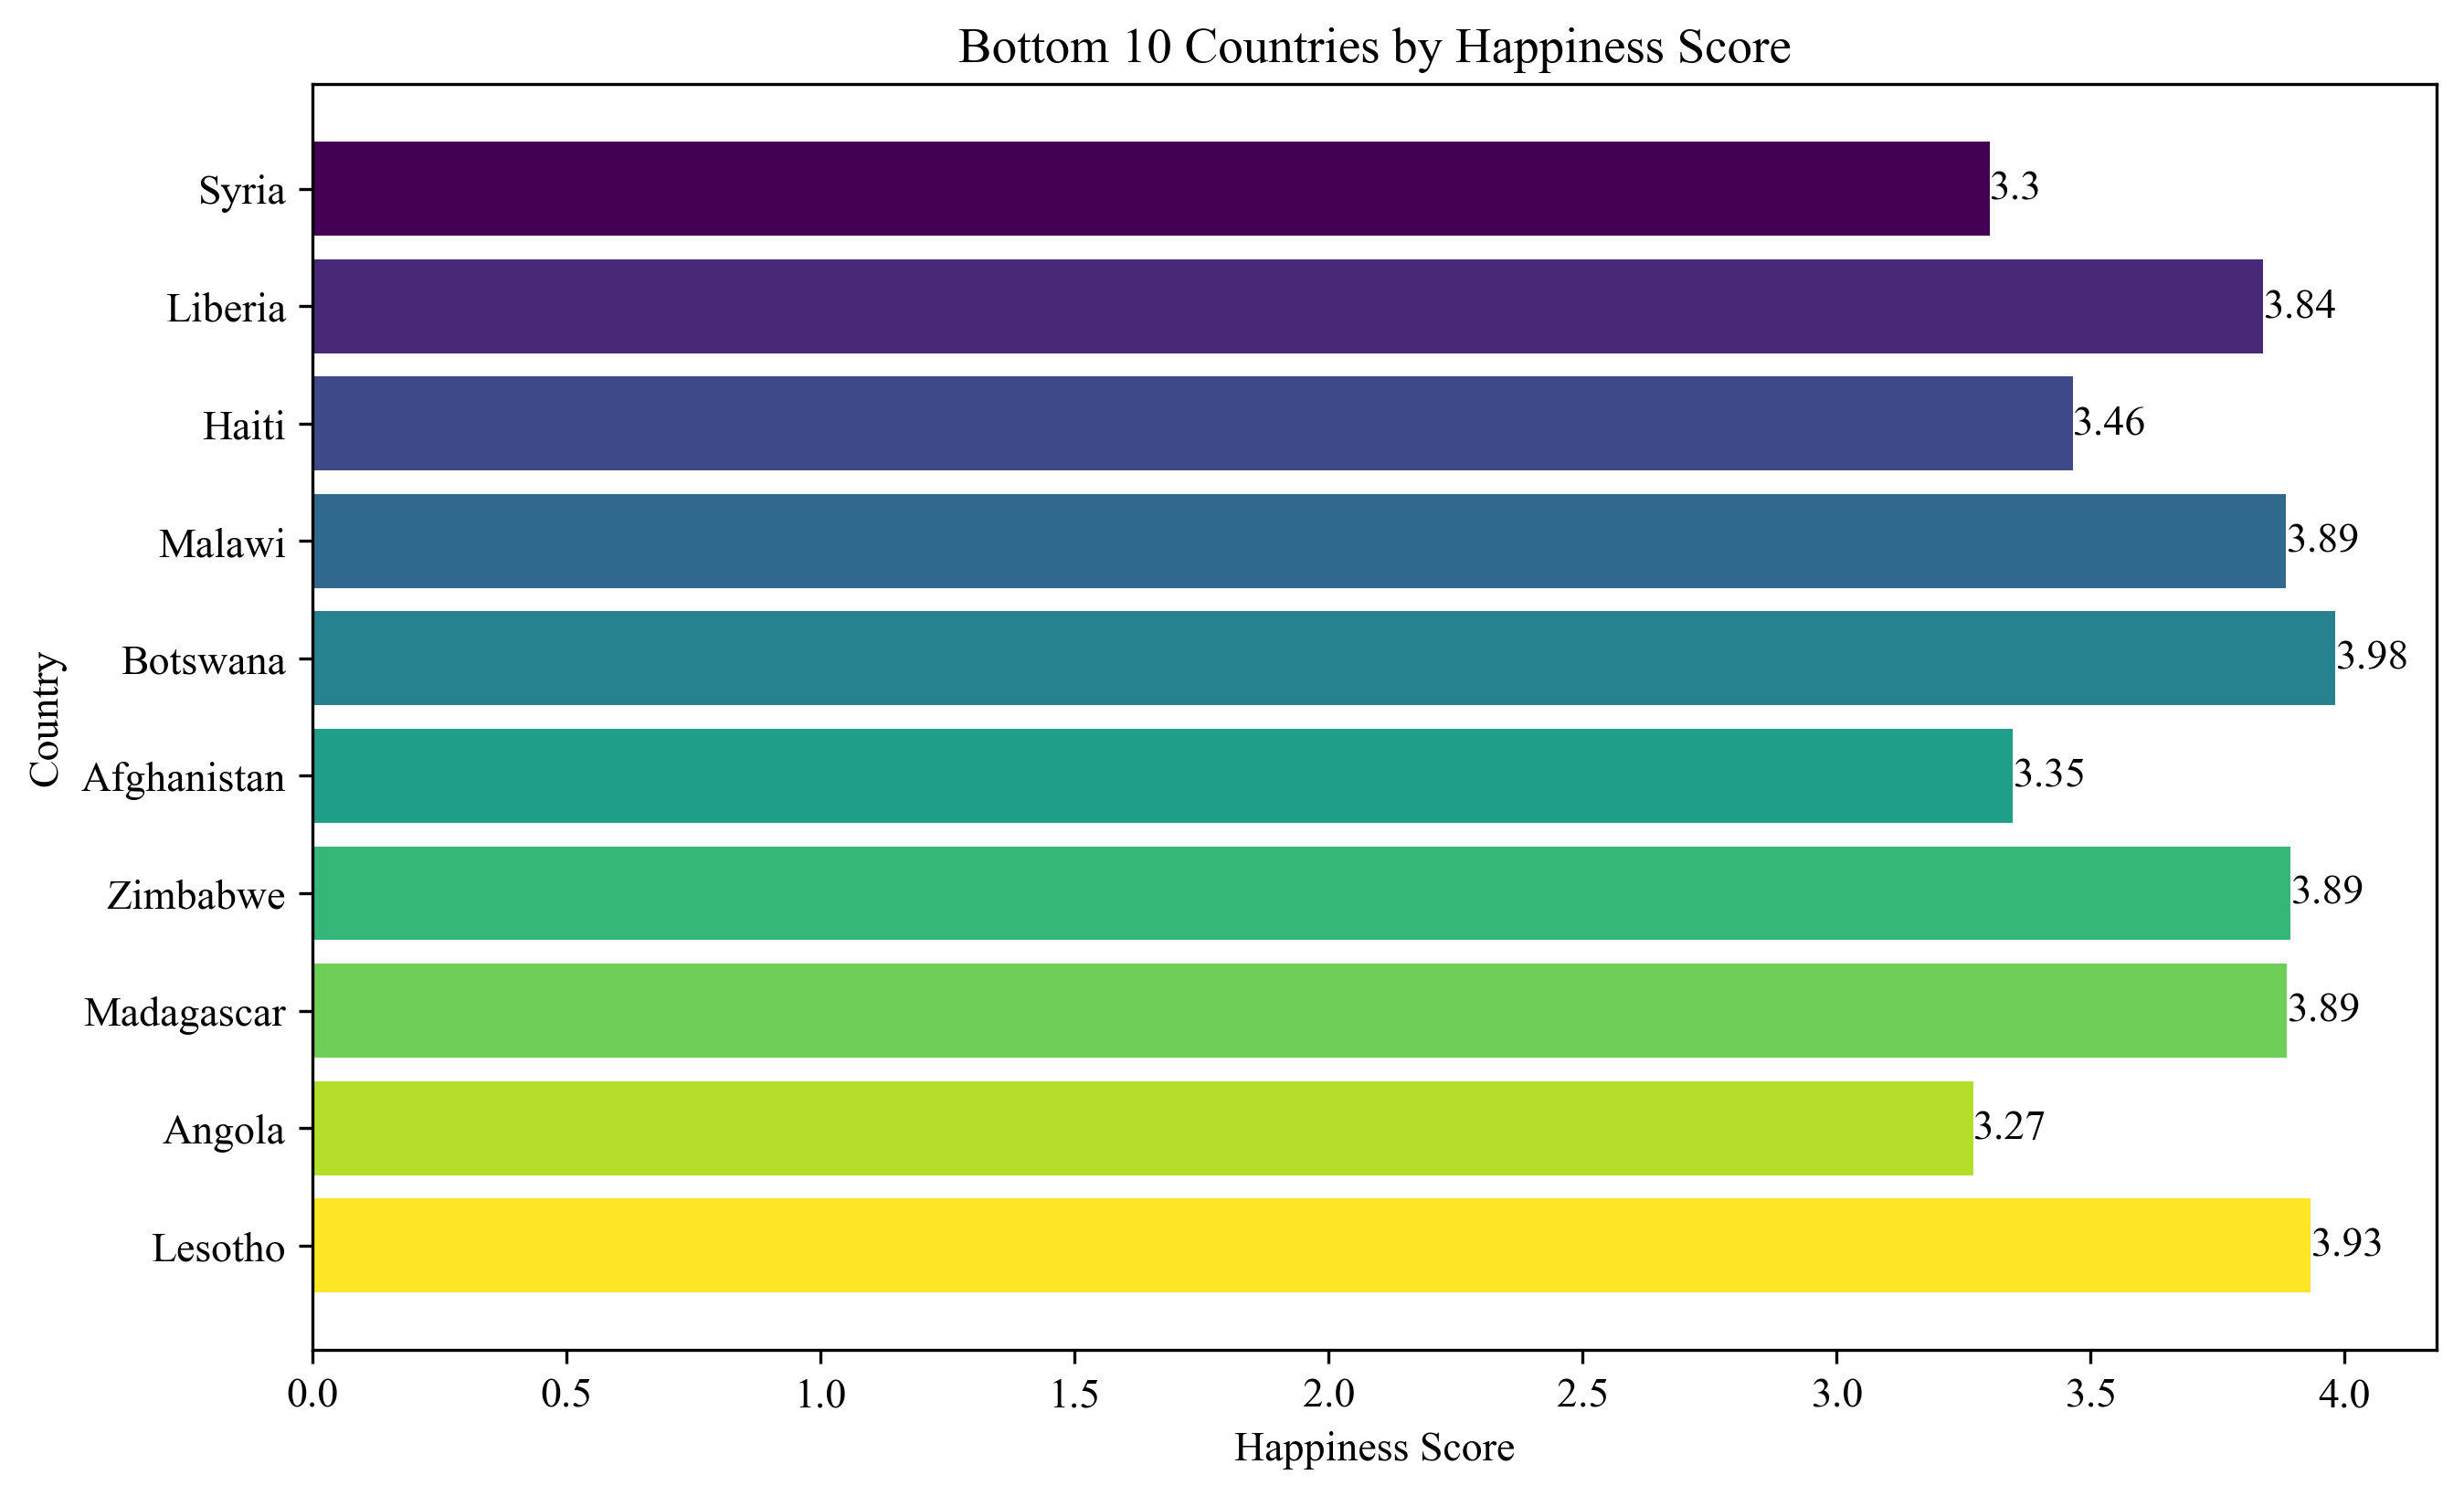

In [20]:

# Select the 10 countries with the lowest happiness scores and sort them in ascending order by rank

bottom_10 = df.nlargest(10, 'Happiness Rank').sort_values(by='Happiness Rank')

# Set the figure resolution
plt.rcParams.update({'font.size': 11})

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 300

# Create a figure with a specified size

plt.figure(figsize=(10, 6))

# Create a custom color map with a smaller color span and reverse it. Here we use a lighter part of the 'viridis' colormap.

colormap = cm.get_cmap('viridis', 10).reversed()

# Plot horizontal bar charts and set colors

for i, country in enumerate(bottom_10['Country']):
    score = bottom_10['Happiness Score 2025'].iloc[i]
    color = colormap(i)
    plt.barh(country, score, color=color)

# Add data labels

for i, country in enumerate(bottom_10['Country']):
    score = bottom_10['Happiness Score 2025'].iloc[i]
    plt.text(score, i, str(round(score, 2)), va='center')

# Set the chart title and axis labels
plt.grid(False)
plt.title('Bottom 10 Countries by Happiness Score')
plt.ylabel('Country')
plt.xlabel('Happiness Score')

# Display the chart

plt.show()